## svm tree classifier for bioinformatics features

Need to install
- graphviz
- sklearn
- pydotplus
- mlxtend

Installs pydotplus for plotting of datatrees, since its not provided w default session. also installing graphviz

In [1]:
#!pip3 install pydotplus
#!pip3 install mlxtend
#!pip3 install yellowbrick

### Load requisite libraries

In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec

%matplotlib inline
%reload_ext autoreload
%autoreload 2

#from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split

from mlxtend.data import iris_data
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler

import os

Stuff for plotting trees

In [3]:
from six import StringIO
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plot data

In [4]:
def plotDT(dtree,featureNames = None,classNames=None):
    dot_data = StringIO()
    export_graphviz(dtree, 
                    out_file=dot_data,  
                    feature_names = featureNames,
                    class_names =  classNames,
                    filled=True, 
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    l=Image(graph.create_png())
    return l

In [5]:
def TestAccuracy(clf,X_test,y_test, display=False):
    
    y_pred  = clf.predict( X_test.values)  
    results = ( y_test.values[:,0]==y_pred )

    if display:
        nEntries, dummy = X_test.shape
        for i in range(nEntries):
            print(X_test.iloc[i])
            print("Class=%s Prediction %s %s\n"%(y_test.values[i,0],y_pred[i],results[i]) )
        #print("prediction",results)

    # accuracy
    nTrue = np.sum( results )
    nTot = np.float( np.shape( results)[0] )
    accuracy = nTrue/nTot
    print("Overall accuracy ",accuracy)

    
def TestAccuracySingle(clf,X_test,Y_test,idx=0):
    
    print(X_test.iloc[idx])
    result = clf.predict( [X_test.values[idx,:]])
    print("prediction",result)
    #print(Y_test.iloc[idx])

In [6]:
#TestAccuracy(clf_entropy,X_test,Y_test,display=True)

### Example with hERG data 

In [7]:
import pandas as pd

In [8]:
os.getcwd()

'/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/my-work/svm/pas-domain/bioinformatics-unbalanced-trafficking'

In [9]:
dataFile = "features-latest-sets1n2.txt"
df = pd.read_csv(dataFile, sep="\s+", comment='#')
df.head()

,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.1567,21.2058,14.4202,3.29401,39.6439,0.279349,1.23560,66.7186,6473.83,1479.93,3.763310,-0.549,-0.43,1,1
1,a57p,20.4290,21.8332,14.5935,3.53135,39.4690,0.144014,1.28151,66.0936,6477.76,1526.79,-0.764827,-0.312,-0.32,0,1
2,a78p,20.8206,21.3096,14.5379,3.19232,39.9190,0.220522,1.12505,65.8526,6479.56,1474.41,0.759351,1.487,-0.32,1,1
3,a85v,20.8686,21.4237,14.6775,3.12031,39.6774,0.232523,1.16450,65.4562,6544.62,1492.34,2.430410,-0.518,0.29,1,1
4,c108r,22.1452,21.1476,15.3975,2.75727,38.2283,0.324033,1.58552,62.7131,6753.12,1548.93,6.958320,0.745,-1.84,1,0


In [10]:
df['FOLDX'] = df['FOLDX'].round(2)
df['CONSERVATION'] = df['CONSERVATION'].round(2)
df['HYDROPHOBICITY'] = df['HYDROPHOBICITY'].round(2)
#df.head()

In [11]:
features=["FOLDX","CONSERVATION","HYDROPHOBICITY"]
output = ["TRAFFICKING"]

#X = df[features1]
X = df[features]
Y = df[output]

In [12]:
#from pandas import DataFrame

#scaler = MinMaxScaler()
#model=scaler.fit(X)
#scaledX=model.transform(X)
#X = DataFrame(scaledX)

In [13]:
X_train, X_test, Y_train, Y_test =\
  train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=50)

<font color=red> Data looks very unbalanced</font>

In [14]:
### upsample the minority class, which is benign (class 2 = 0)

In [15]:
# concatenate our traning data back together
#C = pd.concat([X_train, Y_train], axis=1)

In [16]:
#group = C.groupby('TRAFFICKING')
#trafficking=list(group)[1][1]
#nontrafficking=list(group)[0][1]

In [17]:
#nontrafficking_upsampled = resample(nontrafficking,
#                            replace=True, #sample with replacement
#                            n_samples=len(trafficking), #match number in majority class
#                            random_state=50 #reproduce results
 #       )

In [18]:
#combine majority and upsampled minority
#upsampled = pd.concat([trafficking, nontrafficking_upsampled])

Using class_weight="balanced" to reweight classes based on class frequency

In [19]:
#initializing the classifier and fitting it. using linear kernel since it is easy to plot feature importance, for others hard to interpret
clf_svm = SVC(gamma='auto', random_state=50, max_iter=10000, kernel='linear', probability=True)

In [20]:
# train the classifier with resampled data
#X_train=pd.DataFrame(upsampled, columns=["HELIX","TURNS","COILS","THREE-TEN","BETA","RMSD","HBONDS","SASA","WATERS","FOLDX","CONSERVATION","HYDROPHOBICITY"])
#Y_train=pd.DataFrame(upsampled, columns=["TRAFFICKING"])

model=clf_svm.fit(X_train, Y_train.values.ravel())
#model=clf_svm.fit(scaledX_train, Y_train.values.ravel())

In [21]:
# print training accuracy
print("Training sample accuracy")
TestAccuracy(clf_svm, X_train, Y_train)
#TestAccuracy(clf_svm, scaledX_train, Y_train)

Training sample accuracy
Overall accuracy  0.6730769230769231


In [22]:
#classNames=np.array(['0', '1']) # need to verify, but I think this is correct
classNames=np.array(['non-trafficking', 'trafficking']) # need to verify, but I think this is correct
#plotDT(clf_entropy,featureNames=features, classNames=classNames)

In [23]:
#TestAccuracy(clf_entropy,X_test,Y_test, display=True)
print('Test Accuracy')
TestAccuracy(clf_svm, X_test, Y_test)

Test Accuracy
Overall accuracy  0.6521739130434783


In [24]:
y_predict = clf_svm.predict(X_test.values)

In [25]:
# Print overall classification metrics
print(classification_report(Y_test, y_predict, target_names=classNames))

                 precision    recall  f1-score   support

non-trafficking       1.00      0.33      0.50        12
    trafficking       0.58      1.00      0.73        11

       accuracy                           0.65        23
      macro avg       0.79      0.67      0.62        23
   weighted avg       0.80      0.65      0.61        23



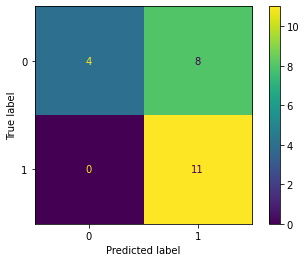

In [26]:
#print(confusion_matrix(Y_test, y_predict))
plot_confusion_matrix(clf_svm, X_test, Y_test)
plt.savefig('svm_cm.pdf')

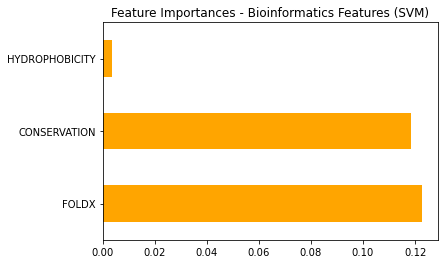

In [27]:
# print feature importance
#this option to plot importance features only apply to linear kernel in SVM
pd.Series(abs(clf_svm.coef_[0]), index=X.columns).nlargest(15).plot(kind='barh', color="orange")
plt.title('Feature Importances - Bioinformatics Features (SVM)')
plt.savefig('svm_fi_bio_features.png', bbox_inches='tight')

In [28]:
F=df[['FOLDX']]
CO=df[["CONSERVATION"]]
HY=df[["HYDROPHOBICITY"]]

Y = df["TRAFFICKING"]

#redifined the classifier for one feature
clf_svm = SVC(gamma='auto', random_state=50, max_iter=10000, kernel='linear', probability=True)

#entire model
y_predict = clf_svm.fit(X_train,Y_train.values.ravel()).predict_proba(X_test)
fpr, tpr, thr = metrics.roc_curve(Y_test, y_predict[:,1])
auc = metrics.auc(fpr, tpr)

#foldx
fx_train, fx_test, fy_train, fy_test = train_test_split(F, Y, train_size=0.7, test_size=0.3, random_state=50)
fy_predict = clf_svm.fit(fx_train, fy_train).predict_proba(fx_test)
f_foldx, t_foldx, th_foldx = metrics.roc_curve(fy_test, fy_predict[:,1], pos_label=1, drop_intermediate=False)
foldx_auc = metrics.auc(f_foldx, t_foldx)

#hydrophobicity
hyx_train, hyx_test, hyy_train, hyy_test = train_test_split(HY, Y, train_size=0.7, test_size=0.3, random_state=50)
hyy_predict = clf_svm.fit(hyx_train, hyy_train).predict_proba(hyx_test)
f_hydr, t_hydr, th_hydr = metrics.roc_curve(hyy_test, hyy_predict[:,1], drop_intermediate=False)
hydr_auc = metrics.auc(f_hydr, t_hydr)

#conservation
cox_train, cox_test, coy_train, coy_test = train_test_split(CO, Y, train_size=0.7, test_size=0.3, random_state=50)
coy_score = clf_svm.fit(cox_train, coy_train).predict_proba(cox_test)
f_cons, t_cons, th_cons = metrics.roc_curve(coy_test, coy_score[:,1], pos_label=1, drop_intermediate=False)
cons_auc = metrics.auc(f_cons, t_cons)


In [29]:
print(fpr)
print(tpr)
print(auc)

[0.         0.08333333 0.66666667 0.66666667 0.75       0.75
 0.83333333 0.83333333 0.91666667 0.91666667 1.         1.        ]
[0.         0.         0.         0.09090909 0.09090909 0.18181818
 0.18181818 0.27272727 0.27272727 0.72727273 0.72727273 1.        ]
0.10606060606060608


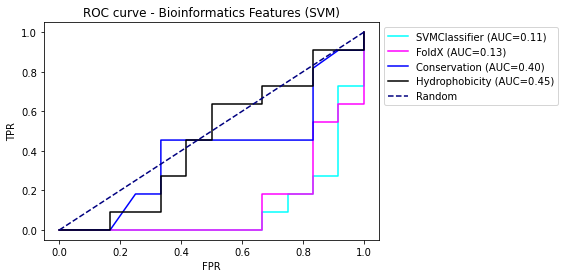

In [31]:
#plot the roc curves of rmsd, waters and hbonds. auc is area under the curve
#plt.figure(figsize=(5, 5))
#plot_roc_curve(clf_svm, X_test, Y_test, color='cyan')
plt.plot (fpr, tpr, color='cyan', label="SVMClassifier (AUC=%0.2f)"%auc)
plt.plot (f_foldx, t_foldx, color='magenta', label="FoldX (AUC=%0.2f)"% foldx_auc)
plt.plot (f_cons, t_cons, color='blue', label="Conservation (AUC=%0.2f)"% cons_auc)
plt.plot (f_hydr, t_hydr, color='black', label="Hydrophobicity (AUC=%0.2f)"% hydr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

plt.title('ROC curve - Bioinformatics Features (SVM)')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('svm_roc_bio_features.pdf', bbox_inches='tight')